# Course 2 Project: ML Pipeline for Feature Engineering

## Instructions

In this project, you'll use data related to microeconomic indicators and historical stock prices to explore the data engineering pipline. You'll get to practice:

* Data ingestion 
* Data cleaning
* Data imputation
* Exploratory data analysis (EDA) through charts and graphs

## Packages

You'll use `pandas` and `matplotlib`, which were covered in the course material, to import, clean, and plot data. They have been installed in this workspace for you. If you're working locally and you installed Jupyter using Anaconda, these packages will already be installed. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install scikit-learn
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 54.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 28.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 29.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Load data

The first step in a data engineering pipeline for machine learning is to ingest the data that will be used. For this project, data is hosted on a public GitHub repo. 

Your tasks:
* Import data from the provided GitHub repo using `pandas`
* Verify that the data has been imported correctly into `pandas` dataframes. Use methods like `head()` and `info()`
* You may need to change column names to make them easier to work with
* You may need to cast datetime data to the `datetime` format using `pandas` `to_datetime()` method

Data files to import: 
1. GDP
2. Inflation 
3. Apple stock prices 
4. Microsoft stock prices

In [3]:
# Load historical GDP data
df_GDP = pd.read_csv('https://raw.githubusercontent.com/udacity/CD13649-Project/refs/heads/main/Project/GDP.csv')
df_inflation = pd.read_csv('https://raw.githubusercontent.com/udacity/CD13649-Project/refs/heads/main/Project/inflation_monthly.csv')

In [4]:
# Check the first few rows of data
df_GDP.head()

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [5]:
# Load the historical stock price data for Apple and Microsoft
Microsoft_Hist_Data= pd.read_csv('https://raw.githubusercontent.com/udacity/CD13649-Project/refs/heads/main/Project/microsoft_historical_data.csv')
Apple_Hist_Data = pd.read_csv('https://raw.githubusercontent.com/udacity/CD13649-Project/refs/heads/main/Project/apple_historical_data.csv')

#Combino los 2 Data Frames:
hist_data = pd.concat([Microsoft_Hist_Data, Apple_Hist_Data], keys=['MSFT', 'AAPL'])
hist_data.reset_index(level=1, drop=True, inplace=True)
hist_data.index.name = 'Ticker'

hist_data


,Date,Close/Last,Volume,Open,High,Low
Ticker,,,,,,
MSFT,05/03/2024,$406.66,17446720,$402.28,$407.15,$401.86
MSFT,05/02/2024,$397.84,17709360,$397.66,$399.93,$394.6515
MSFT,05/01/2024,$394.94,23562480,$392.61,$401.7199,$390.31
MSFT,04/30/2024,$389.33,28781370,$401.49,$402.16,$389.17
MSFT,04/29/2024,$402.25,19582090,$405.25,$406.32,$399.19
...,...,...,...,...,...,...
AAPL,5/12/2014,$21.17,212736019,$20.98,$21.20,$20.98
AAPL,5/9/2014,$20.91,291068564,$20.88,$20.94,$20.73
AAPL,5/8/2014,$21.00,228973884,$21.01,$21.23,$20.94


In [6]:
# Check the first few rows of data
hist_data.head()


,Date,Close/Last,Volume,Open,High,Low
Ticker,,,,,,
MSFT,05/03/2024,$406.66,17446720,$402.28,$407.15,$401.86
MSFT,05/02/2024,$397.84,17709360,$397.66,$399.93,$394.6515
MSFT,05/01/2024,$394.94,23562480,$392.61,$401.7199,$390.31
MSFT,04/30/2024,$389.33,28781370,$401.49,$402.16,$389.17
MSFT,04/29/2024,$402.25,19582090,$405.25,$406.32,$399.19


In [7]:
# Use methods like .info() and .describe() to explore the data
print(hist_data.info())
print(hist_data.describe())



<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, MSFT to AAPL
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        5034 non-null   object
 1   Close/Last  5031 non-null   object
 2   Volume      5034 non-null   int64 
 3   Open        5034 non-null   object
 4   High        5034 non-null   object
 5   Low         5034 non-null   object
dtypes: int64(1), object(5)
memory usage: 275.3+ KB
None
             Volume
count  5.034000e+03
mean   7.863525e+07
std    7.219126e+07
min    7.425603e+06
25%    2.638352e+07
50%    5.186602e+07
75%    1.082150e+08
max    7.576780e+08


## Data preprocessing: Check for missing data and forward fill

Check the Apple historical prices for missing data. Check for missing data in all columns. If there's data missing, use a forward fill to fill in those missing prices. 

In [8]:
# Check for nulls 
hist_data.isnull().sum()


Date          0
Close/Last    3
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [9]:
# Forward fill any missing data
hist_data.fillna(method='ffill', inplace=True)

/tmp/ipykernel_13/3037167755.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hist_data.fillna(method='ffill', inplace=True)


In [10]:
# Check again for nulls after using forward fill
hist_data.isnull().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

## Data preprocessing: Remove special characters and convert to numeric/datetime

The next step in the data engineering process is to standardize and clean up data. In this step, you'll check for odd formatting and special characters that will make it difficult to work with data as numeric or datetime. 

In this step:
* Create a function that takes in a dataframe and a list of columns and removes dollar signs ('$') from those columns
* Convert any columns with date/time data into a `pandas` `datetime` format

In [11]:
def convert_dollar_columns_to_numeric(df, numeric_columns):
    '''
        Removes dollar signs ('$') from a list of columns in a given dataframe AND casts the columns to a numeric datatype.
        Updates dataframe IN PLACE.
        
        Inputs:
            df: dataframe to be operated on
            numeric_columns: columns that should have numeric data but have dollar signs currently
            
        Returns:
            None - changes to the dataframe can be made in place
    '''
    for columna in columnas:
        # Eliminar el signo '$' y convertir a tipo numérico
        df[columna] = df[columna].replace({'\$': ''}, regex=True).astype(float)
    
    return df


In [12]:
# Use convert_dollar_columns_to_numeric() to remove the dollar sign from the Apple and Microsoft datasets
columnas = ['Close/Last', 'Volume', 'Open', 'High', 'Low']
hist_data = convert_dollar_columns_to_numeric(hist_data, columnas)

hist_data

,Date,Close/Last,Volume,Open,High,Low
Ticker,,,,,,
MSFT,05/03/2024,406.66,17446720.0,402.28,407.1500,401.8600
MSFT,05/02/2024,397.84,17709360.0,397.66,399.9300,394.6515
MSFT,05/01/2024,394.94,23562480.0,392.61,401.7199,390.3100
MSFT,04/30/2024,389.33,28781370.0,401.49,402.1600,389.1700
MSFT,04/29/2024,402.25,19582090.0,405.25,406.3200,399.1900
...,...,...,...,...,...,...
AAPL,5/12/2014,21.17,212736019.0,20.98,21.2000,20.9800
AAPL,5/9/2014,20.91,291068564.0,20.88,20.9400,20.7300
AAPL,5/8/2014,21.00,228973884.0,21.01,21.2300,20.9400


In [13]:
# Use pandas's to_datetime() to convert any columns that are in a datetime format

hist_data['Date']=pd.to_datetime(hist_data['Date'])
hist_data.set_index('Date', append=True, inplace=True)
hist_data.head()

Close/Last      Volume    Open      High       Low
Ticker Date                                                          
MSFT   2024-05-03      406.66  17446720.0  402.28  407.1500  401.8600
       2024-05-02      397.84  17709360.0  397.66  399.9300  394.6515
       2024-05-01      394.94  23562480.0  392.61  401.7199  390.3100
       2024-04-30      389.33  28781370.0  401.49  402.1600  389.1700
       2024-04-29      402.25  19582090.0  405.25  406.3200  399.1900

In [14]:
# Use .info() and check the type of each column to ensure that the above steps worked
hist_data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5034 entries, ('MSFT', Timestamp('2024-05-03 00:00:00')) to ('AAPL', Timestamp('2014-05-06 00:00:00'))
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  5034 non-null   float64
 1   Volume      5034 non-null   float64
 2   Open        5034 non-null   float64
 3   High        5034 non-null   float64
 4   Low         5034 non-null   float64
dtypes: float64(5)
memory usage: 295.8+ KB


## Data preprocessing: Align datetime data

Data engineering includes changing data with a datetime component if needed so that different time series can be more easily compared or plotted against each other. 

In this step:

* Align the inflation date so that it falls on the last day of the month instead of the first

Helpful hints: 
* Use the `pandas` `offsets` method using `MonthEnd(0)` to set the 'Date' column to month-end

In [15]:
# Align inflation data so that the date is the month end (e.g. Jan 31, Feb 28/28)
df_inflation['DATE'] = pd.to_datetime(df_inflation['DATE'])
df_inflation['DATE'] = df_inflation['DATE'] + pd.offsets.MonthEnd(0)

df_inflation.rename(columns={'DATE': 'Date', 'CORESTICKM159SFRBATL':'Inflation'}, inplace=True)

df_inflation

,Date,Inflation
0,1968-01-31,3.651861
1,1968-02-29,3.673819
2,1968-03-31,4.142164
3,1968-04-30,4.155828
4,1968-05-31,4.088245
...,...,...
670,2023-11-30,4.688293
671,2023-12-31,4.554396
672,2024-01-31,4.603922
673,2024-02-29,4.403102


## Data preprocessing: Upsample, downsample and interpolate data

Inflation data is presented monthly in this dataset. However, for some models, you may need it at a quarterly frequency, and for some models you may need it at a quarterly frequency. 

In this step:
* Create a new quarterly inflation dataframe by downsampling the monthly inflation data to quarterly using the mean (e.g. for quarter 1 in a given year, use the average values from January, February, and March)
* Create a new weekly inflation dataframe by upsampling the monthly inflation data. For this, you'll need to use `resample` and then you'll need to `interpolate` to fill in the missing data at the weekly frequency

Note that you may need to change the index for some of these operations! 

In [16]:
# Upsample and interpolate from monthly to weekly 
df_inflation.set_index('Date', inplace=True)
df_inflation_semanal = df_inflation.resample('W').interpolate(method='linear')
print(df_inflation_semanal.isna().sum())
df_inflation_semanal = df_inflation_semanal.dropna()
print(df_inflation_semanal)

Inflation    8
dtype: int64
            Inflation
Date                 
1968-03-31   4.142164
1968-04-07   4.173195
1968-04-14   4.204226
1968-04-21   4.235258
1968-04-28   4.266289
...               ...
2024-03-03   4.523115
2024-03-10   4.519639
2024-03-17   4.516164
2024-03-24   4.512688
2024-03-31   4.509212

[2923 rows x 1 columns]


In [17]:
# Downsample from monthly to quarterly 

df_inflation_trimestral = df_inflation.resample('Q').mean()
df_inflation_trimestral

/tmp/ipykernel_13/820342588.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_inflation_trimestral = df_inflation.resample('Q').mean()


,Inflation
Date,
1968-03-31,3.822615
1968-06-30,4.263214
1968-09-30,4.882643
1968-12-31,5.429443
1969-03-31,5.873770
...,...
2023-03-31,6.467833
2023-06-30,5.942054
2023-09-30,5.179249


## Data preprocessing: Normalize/standardize a feature

Economic time series data often involve variables measured on different scales (e.g., GDP in trillions of dollars, inflation in percentage points). Standardizing these variables (typically by subtracting the mean and dividing by the standard deviation) puts them on a common scale, allowing for meaningful comparisons and analyses.

Your task:
* Standardize the GDP data. You may do this manually by subtracting the mean and dividing by the standard deviation, or you may use a built-in method from a library like `sklearn`'s `StandardScaler`

In [18]:
# Standardize the GDP measure
df_GDP['DATE'] = pd.to_datetime(df_GDP['DATE'])
df_GDP.rename(columns={'DATE': 'Date'}, inplace=True)
df_GDP.set_index('Date', inplace=True)


scaler = StandardScaler()

# Ajustar y transformar los datos
df_GDP['GDP'] = scaler.fit_transform(df_GDP[['GDP']])

df_GDP
df_GDP.describe()


,GDP
count,3.090000e+02
mean,-1.839593e-16
std,1.001622e+00
min,-9.354964e-01
25%,-8.602482e-01
50%,-3.805131e-01
75%,7.097946e-01
max,2.820281e+00


In [19]:
# Check the dataframe to make sure the calculation worked as expected 
df_GDP.describe()


,GDP
count,3.090000e+02
mean,-1.839593e-16
std,1.001622e+00
min,-9.354964e-01
25%,-8.602482e-01
50%,-3.805131e-01
75%,7.097946e-01
max,2.820281e+00


## EDA: Plotting a time series of adjusted open vs close price

As part of your EDA, you'll frequently want to plot two time series on the same graph and using the same axis to compare their movements. 

Your task:
* Plot the Apple open and close price time series on the same chart **for the last three months only**. Be sure to use a legend to label each line

**NOTE**: This is a large dataset. If you try to plot the entire series, your graph will be hard to interpret and may take a long time to plot. Be sure to use only the most recent three months of data. 

In [20]:
# Get max date in timeseries
#hist_data.loc['AAPL']
max_date = hist_data.loc['AAPL'].index.get_level_values('Date').max()
max_date

Timestamp('2024-05-03 00:00:00')

In [21]:
# Use the max date calculated above to get the last three months of data in the dataset 
Last_3_months_AAPL = hist_data.loc['AAPL'][hist_data.loc['AAPL'].index.get_level_values('Date') >= (max_date - pd.DateOffset(months=3))]

Last_3_months_AAPL

,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-05-03,183.38,163224100.0,186.65,187.00,182.66
2024-05-02,173.03,94214920.0,172.51,173.42,170.89
2024-05-01,169.30,50383150.0,169.58,172.71,169.11
2024-04-30,170.33,65934780.0,173.33,174.99,170.00
2024-04-29,173.50,68169420.0,173.37,176.03,173.10
...,...,...,...,...,...
2024-02-09,188.85,45155220.0,188.65,189.99,188.00
2024-02-08,188.32,40962050.0,189.39,189.54,187.35
2024-02-07,189.41,53438960.0,190.64,191.05,188.61


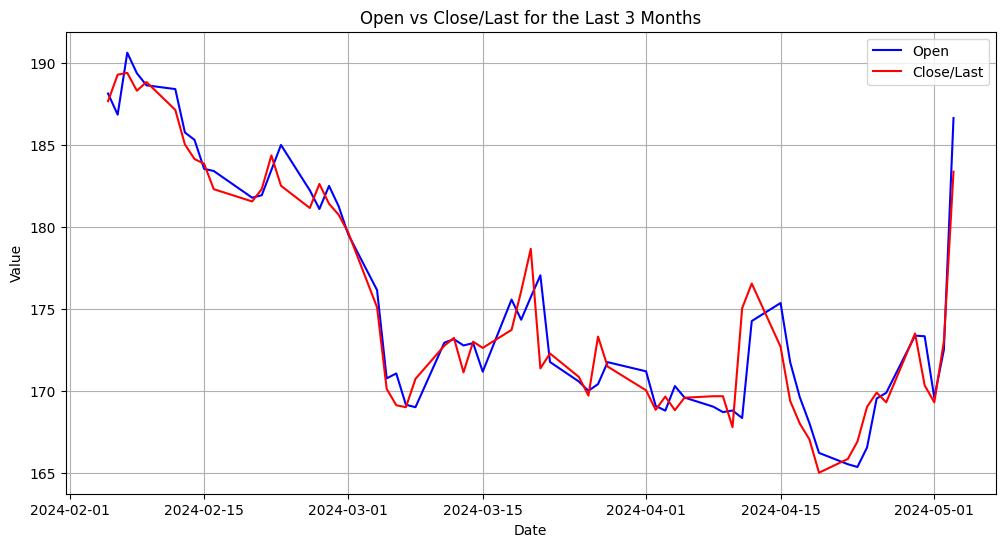

In [22]:
# Plot time series of open v. close stock price for Apple using the last 3 months of data

plt.figure(figsize=(12, 6))


plt.plot(Last_3_months_AAPL['Open'], label='Open', color='blue')
plt.plot(Last_3_months_AAPL['Close/Last'], label='Close/Last', color='red')

# Configuración del gráfico
plt.title('Open vs Close/Last for the Last 3 Months')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.show()


## EDA: Plotting a histogram of a stock's closing price in the last three months

One way to see how much a stock's price generally moves is to plot the frequency of closing prices over a set time period. 

Your task:
* Use the **last three months** of Apple stock data and plot a histogram of closing price

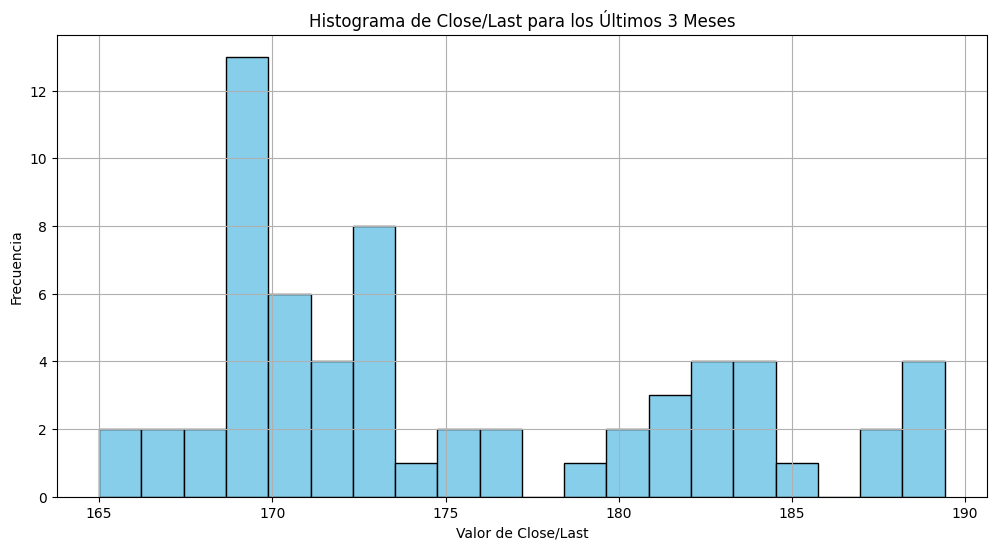

In [23]:
# Plot the histogram of Apple's closing price over the last 3 months 
plt.figure(figsize=(12, 6))
plt.hist(Last_3_months_AAPL['Close/Last'], bins=20, color='skyblue', edgecolor='black')

plt.title('Histograma de Close/Last para los Últimos 3 Meses')
plt.xlabel('Valor de Close/Last')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()


## Calculating correlation between a stock price and a macroeconomic variable 

Inflation affects the purchasing power of money and can influence corporate profits, interest rates, and consumer behavior. By analyzing the correlation between stock prices and inflation, one can gauge how inflationary trends impact stock market performance. For instance, high inflation might erode profit margins and reduce stock prices, while moderate inflation might indicate a growing economy, benefiting stocks.

Your task:
* Plot a heatmap that shows the correlation between Microsoft and Apple returns and inflation 

This will require several steps:
1. Calculate the returns for Apple and Microsoft and the change in monthly inflation (use the `pct_change` method for each)
2. Interpolate the daily stock returns data to monthly so it can be compared to the monthly inflation data
3. Merge the stock returns (Apple and Microsoft) and inflation data series into a single dataframe
4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change
5. Plot the correlation matrix as a heatmap

### 1. Calculate returns for Microsoft / Apple and the monthly change in inflation

In [24]:
# Calculate daily returns for Apple and Microsoft and the percent change in inflation from month to month
hist_data.rename(columns={'Close/Last':'Close'}, inplace=True)
hist_data['Daily return']=np.nan

hist_data['Daily return'] = hist_data.groupby('Ticker')['Close'].pct_change()
print(hist_data)

print(hist_data.isnull().sum())
hist_data.dropna(inplace=True)
print(hist_data.isnull().sum())


                    Close       Volume    Open      High       Low  \
Ticker Date                                                          
MSFT   2024-05-03  406.66   17446720.0  402.28  407.1500  401.8600   
       2024-05-02  397.84   17709360.0  397.66  399.9300  394.6515   
       2024-05-01  394.94   23562480.0  392.61  401.7199  390.3100   
       2024-04-30  389.33   28781370.0  401.49  402.1600  389.1700   
       2024-04-29  402.25   19582090.0  405.25  406.3200  399.1900   
...                   ...          ...     ...       ...       ...   
AAPL   2014-05-12   21.17  212736019.0   20.98   21.2000   20.9800   
       2014-05-09   20.91  291068564.0   20.88   20.9400   20.7300   
       2014-05-08   21.00  228973884.0   21.01   21.2300   20.9400   
       2014-05-07   21.15  282128727.0   21.26   21.3300   20.9900   
       2014-05-06   21.23  373872650.0   21.49   21.5900   21.2300   

                   Daily return  
Ticker Date                      
MSFT   2024-05-03    

### 2. Interpolate stock returns from daily to monthly

In [25]:
#hist_data.index = hist_data.index.set_levels(pd.to_datetime(hist_data.index.get_level_values('Date')), level='Date')
print(hist_data)
def aggregate_returns(returns):
    return (returns + 1).prod() - 1

hist_data_semanal = hist_data.groupby('Ticker').resample('W', level='Date')['Daily return'].apply(aggregate_returns)

print(hist_data_semanal)

                    Close       Volume    Open      High       Low  \
Ticker Date                                                          
MSFT   2024-05-02  397.84   17709360.0  397.66  399.9300  394.6515   
       2024-05-01  394.94   23562480.0  392.61  401.7199  390.3100   
       2024-04-30  389.33   28781370.0  401.49  402.1600  389.1700   
       2024-04-29  402.25   19582090.0  405.25  406.3200  399.1900   
       2024-04-26  406.32   29694650.0  412.17  413.0000  405.7601   
...                   ...          ...     ...       ...       ...   
AAPL   2014-05-12   21.17  212736019.0   20.98   21.2000   20.9800   
       2014-05-09   20.91  291068564.0   20.88   20.9400   20.7300   
       2014-05-08   21.00  228973884.0   21.01   21.2300   20.9400   
       2014-05-07   21.15  282128727.0   21.26   21.3300   20.9900   
       2014-05-06   21.23  373872650.0   21.49   21.5900   21.2300   

                   Daily return  
Ticker Date                      
MSFT   2024-05-02    

### 3. Merge the dataframes and calculate / plot the correlation

In [26]:
hist_data_reset = hist_data_semanal.reset_index()

hist_data_pivoted = hist_data_reset.pivot(index='Date', columns='Ticker', values='Daily return')

df_combined = pd.merge(hist_data_pivoted, df_inflation_semanal, on='Date', how='inner')

df_combined.rename(columns={df_inflation_semanal.columns[0]: 'Inflation'}, inplace=True)

print(df_combined)

                AAPL      MSFT  Inflation
Date                                     
2014-05-11  0.002834 -0.022767   1.936730
2014-05-18 -0.019453  0.005535   1.938122
2014-05-25 -0.033572 -0.010948   1.939515
2014-06-01 -0.004900 -0.014709   1.940908
2014-06-08 -0.041827 -0.011631   1.942301
...              ...       ...        ...
2024-03-03  0.034609 -0.017787   4.523115
2024-03-10  0.013603  0.025709   4.519639
2024-03-17 -0.005584 -0.030672   4.516164
2024-03-24  0.016798 -0.013101   4.512688
2024-03-31  0.004823 -0.004028   4.509212

[517 rows x 3 columns]


### 4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change

In [27]:
# Calculate correlation matrix
correlation_matrix = df_combined.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

               AAPL      MSFT  Inflation
AAPL       1.000000  0.616350   0.042511
MSFT       0.616350  1.000000   0.025066
Inflation  0.042511  0.025066   1.000000


### 5. Plot the correlation matrix as a heatmap 

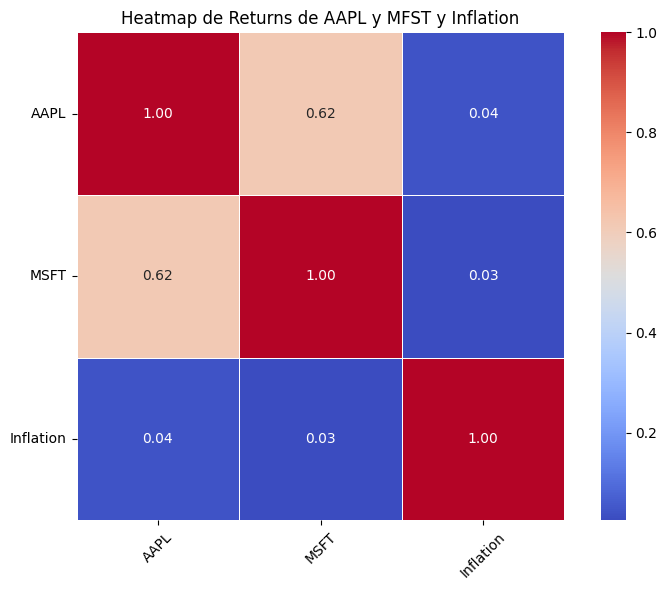

In [28]:
# Plot heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    linewidths=0.5, 
    square=True
)

# Títulos y etiquetas
plt.title("Heatmap de Returns de AAPL y MFST y Inflation")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Calculating rolling volatility (standard deviation) of a stock's price for last 3 months

Volatility is a measure of the dispersion of returns for a given security. By calculating rolling volatility, investors can assess the risk associated with a stock over time: Higher volatility indicates higher risk, as the stock's price is more likely to experience significant fluctuations. In portfolio optimization, understanding the volatility of individual stocks and how it changes over time is crucial for diversification and optimization. By analyzing rolling volatility, investors can adjust their portfolios to maintain a desired risk level, potentially improving the risk-return profile.

One possible way to calculate volatility is by using the standard deviation of returns for a stock over time.

Your task:
* Calculate the weekly rolling standard deviation for Apple's closing price
* Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price. Plot these **on the same chart, but using different y-axes**

Helpful hints:
* You'll need to use the `pandas` `rolling()` method with a given `window_size` parameter to make it a _weekly_ rolling calculation
* Use **only the last three months of data**; data much older than this may not be as useful for portfolio optimization
* You'll need to create two axes on the matplotlib figure to be able to use two different y-axes (one for the closing price and one for the rolling volatility calculated here)

In [29]:
# Define the window size for the rolling calculation (e.g., one week)
ventana_rolling = 7

In [51]:
# Calculate rolling one-week volatility

hist_data_AAPL_sorted = hist_data.loc['AAPL'].sort_index()
print(hist_data_AAPL_sorted)

last_date = hist_data_AAPL_sorted.index.get_level_values('Date').max()
three_months_ago = last_date - pd.DateOffset(months=3)
print(last_date)

hist_data_AAPL_3m = hist_data_AAPL_sorted.loc[hist_data_AAPL_sorted.index.get_level_values('Date') >= three_months_ago]

# Calcular la desviación estándar semanal móvil
rolling_std = hist_data_AAPL_3m['Daily return'].rolling(window=ventana_rolling).std()
print(rolling_std)
# Añadir la columna al DataFrame original filtrado
hist_data_AAPL_3m['Weekly Rolling Std'] = rolling_std
hist_data_AAPL_3m.dropna(inplace=True)
# Mostrar resultados
#print(hist_data_AAPL_3m) #[['Daily return', 'Weekly Rolling Std']]
print(hist_data_AAPL_3m.columns)
print(hist_data_AAPL_3m[['Daily return', 'Weekly Rolling Std']].head(10))

             Close       Volume    Open    High     Low  Daily return
Date                                                                 
2014-05-06   21.23  373872650.0   21.49   21.59   21.23      0.003783
2014-05-07   21.15  282128727.0   21.26   21.33   20.99      0.007143
2014-05-08   21.00  228973884.0   21.01   21.23   20.94      0.004304
2014-05-09   20.91  291068564.0   20.88   20.94   20.73     -0.012282
2014-05-12   21.17  212736019.0   20.98   21.20   20.98     -0.001886
...            ...          ...     ...     ...     ...           ...
2024-04-26  169.30   44838350.0  169.88  171.34  169.18     -0.024207
2024-04-29  173.50   68169420.0  173.37  176.03  173.10      0.018611
2024-04-30  170.33   65934780.0  173.33  174.99  170.00      0.006084
2024-05-01  169.30   50383150.0  169.58  172.71  169.11     -0.021557
2024-05-02  173.03   94214920.0  172.51  173.42  170.89     -0.056440

[2516 rows x 6 columns]
2024-05-02 00:00:00
Date
2024-02-02         NaN
2024-02-05       

/tmp/ipykernel_13/3983226798.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_data_AAPL_3m['Weekly Rolling Std'] = rolling_std
/tmp/ipykernel_13/3983226798.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_data_AAPL_3m.dropna(inplace=True)


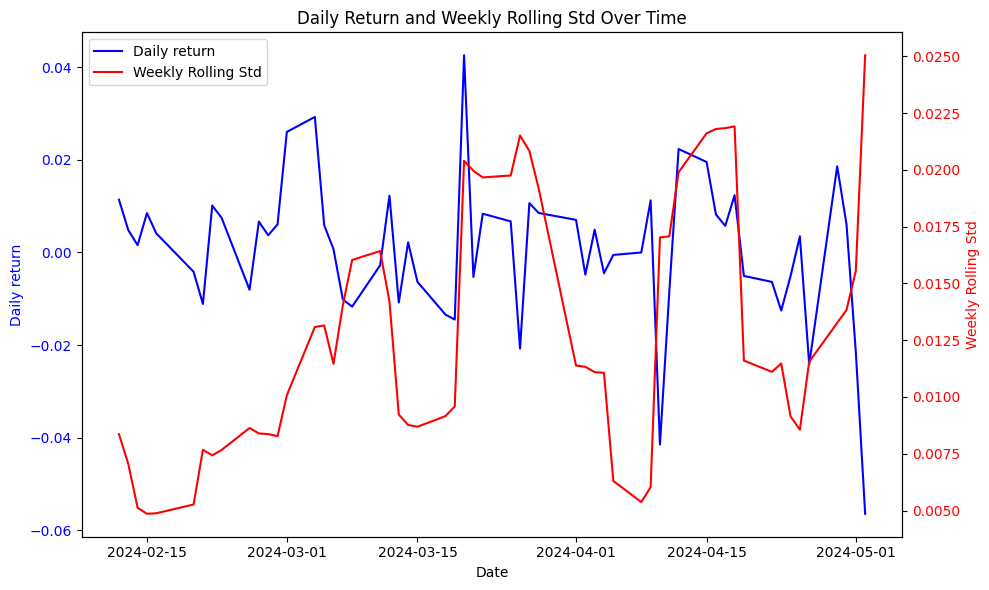

In [41]:
# Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price
# Plot these on the same chart, but using different y-axes
#import matplotlib.pyplot as plt

# Supongamos que hist_data_AAPL_3m ya está definido con sus dos columnas
# y su índice es de tipo datetime.

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera columna ('Daily return') en el primer eje (ax1)
ax1.plot(hist_data_AAPL_3m.index, hist_data_AAPL_3m['Daily return'], color='blue', label='Daily return')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily return', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear un segundo eje y (compartiendo el eje x) para la segunda columna ('Weekly Rolling Std')
ax2 = ax1.twinx()
ax2.plot(hist_data_AAPL_3m.index, hist_data_AAPL_3m['Weekly Rolling Std'], color='red', label='Weekly Rolling Std')
ax2.set_ylabel('Weekly Rolling Std', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Agregar un título
plt.title('Daily Return and Weekly Rolling Std Over Time')

# Opcional: Agregar una leyenda para cada eje
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()



## Export data

Now that you have preprocessed your data, you should save it in new csv files so that it can be used in downstream tasks without having to redo all the preprocessing steps. 

Your task:
* Use `pandas` to export all modified datasets back to new CSV files

In [53]:
df_GDP.to_csv('GDP.csv')
df_combined.to_csv ('hist_data_with_inflation.csv')
hist_data.to_csv('hist_data.csv')
hist_data_AAPL_3m.to_csv('hist_data_AAPL_3m.csv')